# Model to classify 20 tree species based on LeafSnap data subset

### Settings

In [1]:
# Imports
import warnings
warnings.simplefilter('ignore')

import numpy as np
from numpy import load
import os.path
import matplotlib.pyplot as plt
import pandas as pd

import keras.backend as K
if(K.tensorflow_backend):
    import tensorflow as tf
    tf.logging.set_verbosity(tf.logging.ERROR)
from keras.utils import np_utils
from keras.models import load_model

from code import data as d
from code import model as m

Using TensorFlow backend.


### Load the data and split into train, test and validation

In [2]:
original_data_path = "/home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-20subset/"
images_fname = os.path.join(original_data_path, "images.npz")
labels_fname = os.path.join(original_data_path, "labels.npz")
info_fname_rand = os.path.join(original_data_path, "leafsnap-dataset-20subset-images-enhanced-randomized.txt")

# load data
image_data = np.load(images_fname)
labels_data = np.load(labels_fname)
info_data = pd.read_csv(info_fname_rand)

images = image_data['images']
labels_one_hot = labels_data['labels_one_hot']


print('Image size: ', np.shape(images))
print('Labels one hot size: ', np.shape(labels_one_hot))

nim = len(labels_one_hot)
print('Number of images: ', nim)

info_data.tail()

Image size:  (3283, 64, 64, 3)
Labels one hot size:  (3283, 20)
Number of images:  3283


,filename,label,source,label_numeric,path
3278,13002204347915.jpg,Salix nigra,field,14,dataset/images/field/salix_nigra/1300220434791...
3279,wb1193-06-2.jpg,Betula lenta,lab,3,dataset/images/lab/Auto_cropped/betula_lenta/w...
3280,13002204347905.jpg,Salix nigra,field,14,dataset/images/field/salix_nigra/1300220434790...
3281,wb1220-03-2.jpg,Magnolia acuminata,lab,7,dataset/images/lab/Auto_cropped/magnolia_acumi...
3282,pi2201-01-1.jpg,Diospyros virginiana,lab,6,dataset/images/lab/Auto_cropped/diospyros_virg...


### Split the data into train, test and validation

In [3]:
[images_train, images_val, images_test, 
 labels_one_hot_train, labels_one_hot_val, labels_one_hot_test,
 end_train_ind, end_val_ind] = d.split_data(images,labels_one_hot)
print('Image size - train set: ', np.shape(images_train))
print('Labels size - train set: ', np.shape(labels_one_hot_train)) 
print('Image size - valid. set: ', np.shape(images_val))
print('Labels size - valid. set: ', np.shape(labels_one_hot_val)) 
print('Image size - test set: ', np.shape(images_test))
print('Labels size - test set: ', np.shape(labels_one_hot_test)) 

print('Indicies: ', end_train_ind,', ', end_val_ind)
    

Image size - train set:  (2298, 64, 64, 3)
Labels size - train set:  (2298, 20)
Image size - valid. set:  (328, 64, 64, 3)
Labels size - valid. set:  (328, 20)
Image size - test set:  (657, 64, 64, 3)
Labels size - test set:  (657, 20)
Indicies:  2298 ,  2626


In [4]:
# splitting some of of the info data

labels_train = info_data.loc[:end_train_ind, "label"]
sources_train = info_data.loc[:end_train_ind, "source"]

labels_numeric_test = info_data.loc[end_val_ind:nim, "label_numeric"]
labels_test = info_data.loc[end_val_ind:nim, "label"]
filenames_test = info_data.loc[end_val_ind:nim, "filename"]
sources_test = info_data.loc[end_val_ind:nim, "source"]
path_test = info_data.loc[end_val_ind:nim, "path"]

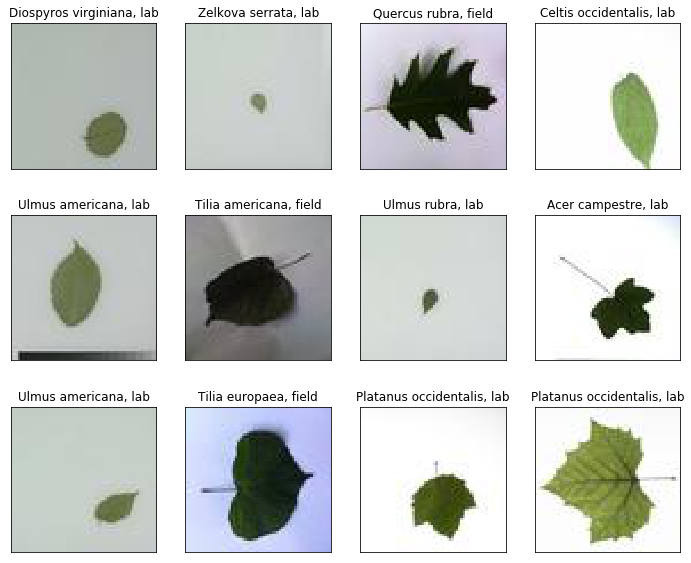

In [5]:
# plot random train images
d.plot_12images(images_train, labels_train, sources_train, figsize=(12,10))

### Data formatting

In [6]:
img_rows = 64
img_cols = 64
img_channels = 3
#print(K.image_data_format())
if K.image_data_format() == 'channels_first':
    images_train = images_train.reshape(images_train.shape[0], img_channels, img_rows, img_cols)
    images_test = images_test.reshape(images_test.shape[0], img_channels, img_rows, img_cols)
    images_val = images_val.reshape(images_val.shape[0], img_channels, img_rows, img_cols)
    input_shape = (img_channels, img_rows, img_cols)
else:
    images_train = images_train.reshape(images_train.shape[0], img_rows, img_cols, img_channels)
    images_test = images_test.reshape(images_test.shape[0], img_rows, img_cols, img_channels)
    images_val = images_val.reshape(images_val.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)
print("Size of training data: ", np.shape(images_train))
print("Size of validation data: ", np.shape(images_val))
print("Size of testing data: ", np.shape(images_test))

Size of training data:  (2298, 64, 64, 3)
Size of validation data:  (328, 64, 64, 3)
Size of testing data:  (657, 64, 64, 3)


## Construct the model

In [7]:
model = m.generate_model(input_shape, 20)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_layer1 (Conv2D)       (None, 60, 60, 16)        1216      
_________________________________________________________________
maxpooling2d_layer1 (MaxPool (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_layer2 (Conv2D)       (None, 26, 26, 32)        12832     
_________________________________________________________________
maxpooling2d_layer2 (MaxPool (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_layer1 (Dropout)     (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_layer1 (Flatten)     (None, 5408)              0         
_________________________________________________________________
dense_layer1 (Dense)         (None, 500)               2704500   
__________

### Train the model

In [8]:
from keras.callbacks import ModelCheckpoint

# autosave best Model
best_model_file = model_fname = os.path.join(original_data_path, 'Models','leafnet.h5')
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose=1, save_best_only=True)

print('Training model...')
batch_size = 32
epochs = 100
model, results = m.train_model(model, images_train, labels_one_hot_train,
                             images_val, labels_one_hot_val, 
                             batch_size, epochs, best_model)
print('Traing finished.')

print('Loading the best model...')
model = load_model(best_model_file)
print('Best Model loaded!')


Training model...
Train on 2298 samples, validate on 328 samples
Epoch 1/100
2298/2298 [==============================] - 14s 6ms/step - loss: 2.9406 - acc: 0.1092 - val_loss: 2.8958 - val_acc: 0.1341

Epoch 00001: val_loss improved from inf to 2.89583, saving model to /home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-20subset/Models/leafnet.h5
Epoch 2/100
2298/2298 [==============================] - 14s 6ms/step - loss: 2.6096 - acc: 0.2084 - val_loss: 2.3544 - val_acc: 0.2500

Epoch 00002: val_loss improved from 2.89583 to 2.35441, saving model to /home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-20subset/Models/leafnet.h5
Epoch 3/100
2298/2298 [==============================] - 12s 5ms/step - loss: 2.3232 - acc: 0.2942 - val_loss: 2.1510 - val_acc: 0.3384

Epoch 00003: val_loss improved from 2.35441 to 2.15098, saving model to /home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-20subset/Models/leafnet.h5
Epoch 4/100
2298/2298 [==============================] - 12s 5ms/step - 

2298/2298 [==============================] - 11s 5ms/step - loss: 0.2597 - acc: 0.9151 - val_loss: 1.3620 - val_acc: 0.6585

Epoch 00037: val_loss did not improve from 1.20447
Epoch 38/100
2298/2298 [==============================] - 11s 5ms/step - loss: 0.2484 - acc: 0.9143 - val_loss: 1.3531 - val_acc: 0.6555

Epoch 00038: val_loss did not improve from 1.20447
Epoch 39/100
2298/2298 [==============================] - 10s 4ms/step - loss: 0.2341 - acc: 0.9164 - val_loss: 1.3754 - val_acc: 0.6890

Epoch 00039: val_loss did not improve from 1.20447
Epoch 40/100
2298/2298 [==============================] - 10s 4ms/step - loss: 0.2257 - acc: 0.9225 - val_loss: 1.4453 - val_acc: 0.6616

Epoch 00040: val_loss did not improve from 1.20447
Epoch 41/100
2298/2298 [==============================] - 10s 4ms/step - loss: 0.2137 - acc: 0.9286 - val_loss: 1.3892 - val_acc: 0.6921

Epoch 00041: val_loss did not improve from 1.20447
Epoch 42/100
2298/2298 [==============================] - 10s 4ms/st

2298/2298 [==============================] - 10s 5ms/step - loss: 0.1030 - acc: 0.9682 - val_loss: 1.6889 - val_acc: 0.6646

Epoch 00080: val_loss did not improve from 1.20447
Epoch 81/100
2298/2298 [==============================] - 12s 5ms/step - loss: 0.0832 - acc: 0.9726 - val_loss: 1.6903 - val_acc: 0.6829

Epoch 00081: val_loss did not improve from 1.20447
Epoch 82/100
2298/2298 [==============================] - 11s 5ms/step - loss: 0.0928 - acc: 0.9691 - val_loss: 1.7248 - val_acc: 0.6768

Epoch 00082: val_loss did not improve from 1.20447
Epoch 83/100
2298/2298 [==============================] - 10s 4ms/step - loss: 0.0744 - acc: 0.9765 - val_loss: 1.5845 - val_acc: 0.6799

Epoch 00083: val_loss did not improve from 1.20447
Epoch 84/100
2298/2298 [==============================] - 11s 5ms/step - loss: 0.0727 - acc: 0.9748 - val_loss: 1.6565 - val_acc: 0.6677

Epoch 00084: val_loss did not improve from 1.20447
Epoch 85/100
2298/2298 [==============================] - 11s 5ms/st

### Test the model

In [9]:
score = model.evaluate(images_test, labels_one_hot_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.2327118179388061
Test accuracy: 0.6423135468767477


### Examine training process

In [10]:
print(results)

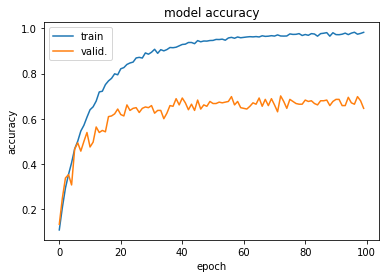

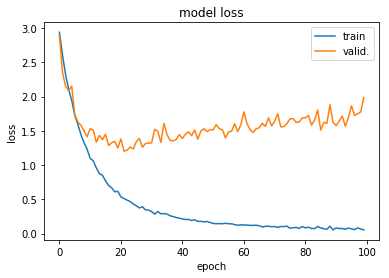

In [11]:
from matplotlib import pyplot as plt

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid.'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid.'], loc='upper right')
plt.show()